In [1]:
%load_ext autoreload
%autoreload 2

import sys
import pickle 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

sys.path.append('../')

from src.training.caseci import *
from src.explainers import *
from src.timelimit import *
from src.explainers import *

pd.set_option('display.max_columns', 500)

import tensorflow as tf

## Get a model

In [2]:
case = CaseCI()

In [3]:
%%capture --no-display
case.train_model()

In [4]:
case.save_pipe(1, 'case_mean_imp')

 ROC AUC train :  0.6738824367934839 
 ROC AUC val :  0.6408452273092748 
 ROC AUC test :  0.6412330366802789 

Precision test :  0.8477747144545097
Recall test :  0.7040641099026903


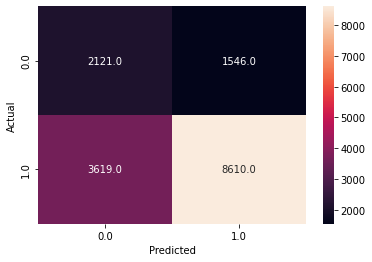

In [5]:
case.print_metrics()

## Changeable features

1.	Общее количество сделок, заключенных с организацией на текущий день. С ростом количества открытых сделок на одного клиента вероятность отказа снижается на 10%. Формулировка задачи: «Проверь по своим клиентам соблюдение контактной политики. Старайся оперативно реагировать на потребности клиента». Выводим, если менее 5 открытых сделок на одного клиента
F_5 (PDP-plot)
2.	Доля завершенных звонков среди всех активностей за 3 дня. С ростом доли звонков среди всех активностей вероятность отказа растет на 1%. «Старайся поддерживать очный контакт с клиентами». Выводим, если более 0.9 доля звонков.
F_12 (PDP-plot)
3.	Среднее количество уникальных продуктов, предложенных клиенту за 3 дня. С ростом количества уникальных предложенных продуктов вероятность отказа растет на 2%. «Старайся точно идентифицировать потребности клиента и не предлагать новые продукты без необходимости». Выводим, если более 4 количество уникальных предложенных продуктов.
F_24 (PDP-plot)
4.	Количество уникальных продуктов, предложенных клиентам за 3 дня. С ростом числа уникальных предложенных продуктов у клиента вероятность отказа растет на 0.9%. «Старайся не предлагать большой ряд продуктов, уточни потребность клиента». Выводим, если более 15 уникальных предложенных клиентам продуктов.
F_18 (PDP-plot)
5.	Среднее количество завершенных встреч и завершенных звонков за 3 дня. Если совершать встречи, вероятность отказа снижается на 0.4%. «Старайся поддерживать очный контакт с клиентом». Выводим, если нет встреч и есть звонки за последние 3 дня.
F_15, F_72 (PDP-plot)



## DiCE Report

### Generate counterfactuals for a sample n=100 using only changeable features

In [6]:
features_to_vary = ['F_5', 'F_12', 'F_24', 'F_18', 'F_15', 'F_72']

In [7]:
dice = DiCeReport(case, desired_class=0, 
                  features_to_vary=features_to_vary)
dice.create_explainer(method='random')

In [8]:
# example for one instance
dice.get_cf(7377, printout=True)

Generating cfs for 7377


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.88s/it]

Query instance (original outcome : 1)


,F_0,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,F_10,F_11,F_12,F_13,F_14,F_15,F_16,F_17,F_18,F_19,F_20,F_21,F_22,F_23,F_24,F_25,F_26,F_27,F_28,F_29,F_30,F_31,F_32,F_33,F_34,F_35,F_36,F_37,F_38,F_39,F_40,F_41,F_42,F_43,F_44,F_45,F_46,F_47,F_48,F_49,F_50,F_51,F_52,F_53,F_54,F_55,F_56,F_57,F_58,F_59,F_60,F_61,F_62,F_63,F_64,F_65,F_66,F_67,F_68,F_69,F_70,F_71,F_72,F_73,F_74,F_75,F_76,F_77,F_78,F_79,F_80,F_81,F_82,F_83,F_84,target
0,0.0,1.0,0.20713,0.0,0.6,0.0,0.5,0.2,0.0,0.071429,0.0,0.526316,1.0,0.175993,6.693604e-17,0.0,0.0,0.482386,0.141361,0.12,0.236559,0.237246,0.292683,0.0,0.0,0.0,0.208508,1.0,0.2,0.121378,0.0,1.0,0.02,0.111111,0.0,0.0,0.098468,0.0,0.0,0.0,0.390244,0.321429,0.035433,0.008156,0.098039,0.299492,0.20234,0.055249,0.138887,0.064363,0.0,0.206897,0.0,0.758621,0.257426,0.0,0.72867,1.0,0.0,0.015991,0.0,0.0,0.257258,0.051282,0.0,0.15311,0.034483,1.0,0.148805,0.756045,0.0,0.049689,0.054096,0.198107,0.0,0.0,0.0,0.84689,0.0,0.008525,0.0,0.0,0.0,0.0,0.662129,1



Diverse Counterfactual set (new outcome: 0.0)


,F_0,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,F_10,F_11,F_12,F_13,F_14,F_15,F_16,F_17,F_18,F_19,F_20,F_21,F_22,F_23,F_24,F_25,F_26,F_27,F_28,F_29,F_30,F_31,F_32,F_33,F_34,F_35,F_36,F_37,F_38,F_39,F_40,F_41,F_42,F_43,F_44,F_45,F_46,F_47,F_48,F_49,F_50,F_51,F_52,F_53,F_54,F_55,F_56,F_57,F_58,F_59,F_60,F_61,F_62,F_63,F_64,F_65,F_66,F_67,F_68,F_69,F_70,F_71,F_72,F_73,F_74,F_75,F_76,F_77,F_78,F_79,F_80,F_81,F_82,F_83,F_84,target
0,-,-,-,-,-,0.1,-,-,-,-,-,-,-,-,-,-,-,-,0.1378331,-,-,-,-,-,-,-,-,-,-,-,-,-,1.02,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0344827582639713,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.0
1,-,-,-,-,-,-,-,-,-,-,-,-,0.6,-,-,-,-,-,0.1983482,-,-,-,-,-,-,-,-,-,-,-,-,-,1.02,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0344827582639713,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.0
2,-,-,-,-,-,0.2,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.02,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0344827582639713,-,-,-,-,-,0.037625669,-,-,-,-,-,-,-,-,-,-,-,-,0.0
3,-,-,-,-,-,-,-,-,-,-,-,-,0.6,-,-,-,-,-,0.19386719,-,-,-,-,-,-,-,-,-,-,-,-,-,1.02,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0344827582639713,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.0
4,-,-,-,-,-,0.1,-,-,-,-,-,-,0.9,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.02,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0344827582639713,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.0


Stopped generating cfs for 7377


In [ ]:
%%capture --no-display
dice.evaluate_dataset(n=1, save=True, name='case_dice_cf_all')

  0%|          | 0/10156 [00:00<?, ?it/s]

In [ ]:
5959

Simulation results on a subset:

In [ ]:
dice.print_metrics()

How dice changes features:

In [ ]:
dice.plot_diffs()

In [ ]:
dice.cfs.keys()

### Generate counterfactuals for a sample n=100 using all features

In [28]:
# %%capture --no-display
# dice2 = DiCeReport(case, desired_class=0)
# dice2.create_explainer()
# dice2.evaluate_dataset(n=100, save=True, 
#                name='case_dice_cf_all_feats',
#                timeout=20) 
#increased timeout because all features take longer time to vary

In [29]:
# dice2.print_metrics()

## LimeReport

  0%|          | 0/37 [00:00<?, ?it/s]

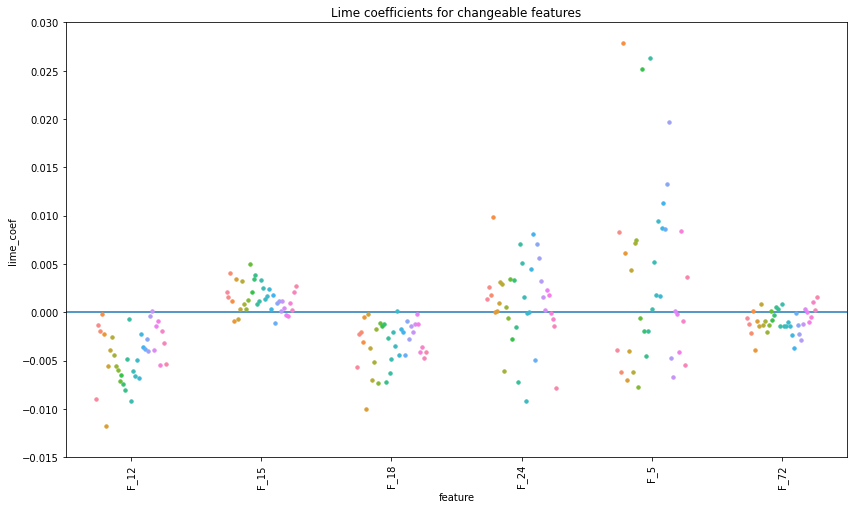

In [30]:
lime = LimeReport(case, desired_class=0, 
                  features_to_vary=features_to_vary)
lime.create_explainer()
lime.evaluate_dataset(dice.cfs)
lime.plot_coefs(-0.015,0.03)

We can see that several features have lime coefficients with different sign for the same instances, means are very close to zero. 

At the same time, for many coefficients are negative (especially for F_18 and F_12), and it doesn't support the DiCE decision to increase the values of this features.

## SLIME - try Stabilized LIME implementation (KDD 2021)

  0%|          | 0/37 [00:00<?, ?it/s]

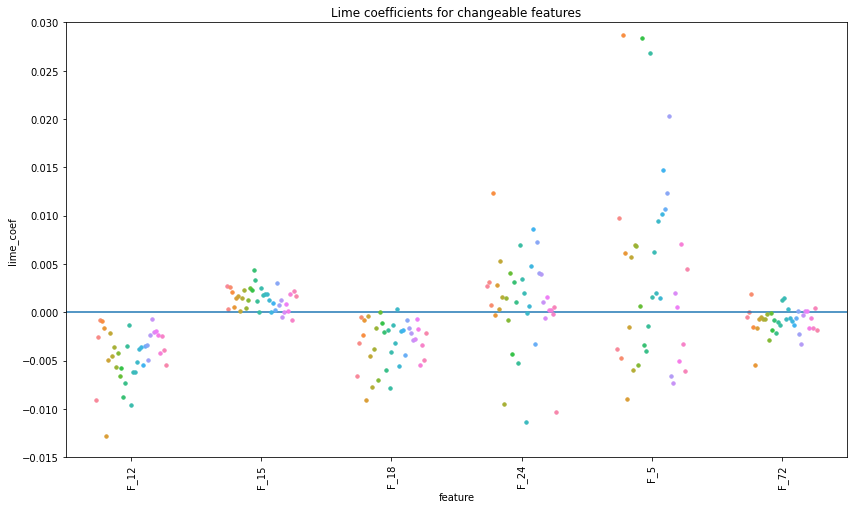

In [31]:
slime = LimeReport(case, desired_class=0, slime=True, 
                  features_to_vary=features_to_vary)
slime.create_explainer()
slime.evaluate_dataset(dice.cfs)
slime.plot_coefs(-0.015,0.03)

Results, in general, are very similar to results of LIME. 

## SHAP

For DiCE subset:

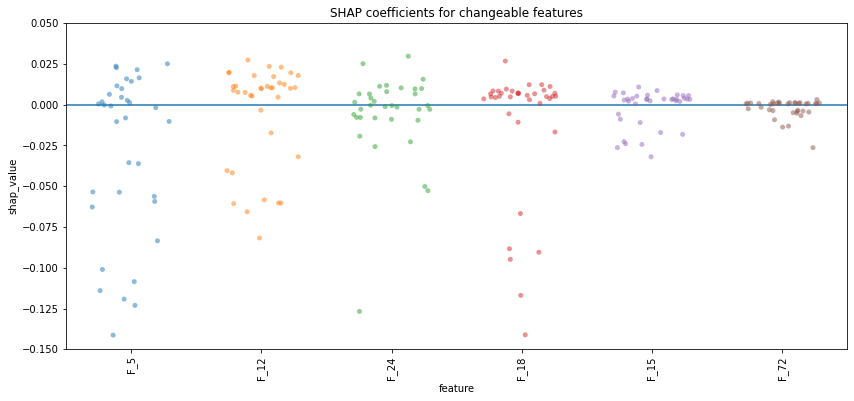

In [32]:
shv = ShapReport(case, desired_class=0, features_to_vary=features_to_vary)
shv.create_explainer()
shv.evaluate_dataset(dice.cfs)
shv.plot_coefs(-0.15,0.05)

For all instances:

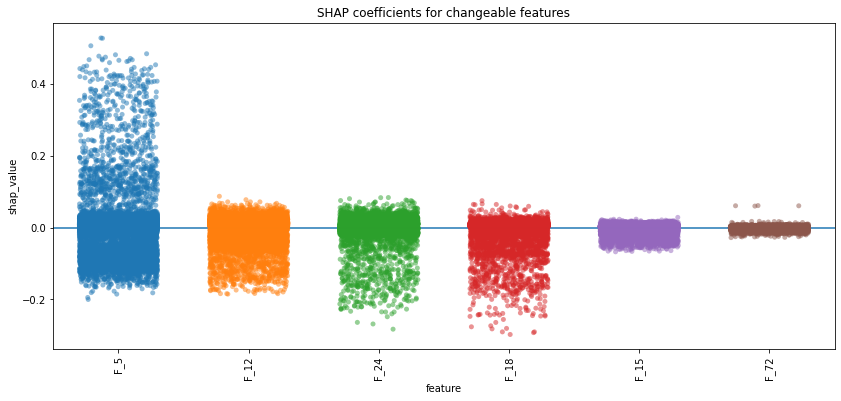

In [33]:
shv = ShapReport(case, desired_class=0, features_to_vary=features_to_vary)
shv.create_explainer()
shv.evaluate_dataset()
shv.plot_coefs()

## Compare results for DiCE, SHAP and SLIME

General comparison:

In [34]:
comp = Comparator(model=case, dice=dice, sh=shv)
comp.compare_dice_slime()

  0%|          | 0/37 [00:00<?, ?it/s]

Share of cases where  SLIME coefficient sign is equal to DiCE suggestion sign:
         % of equal signs
feature                  
F_12                 0.00
F_18                 1.41
F_72                43.64
F_5                 54.72
F_24                76.39
F_15                77.78


In [35]:
comp.compare_dice_shap()

Share of cases where SHAP coefficient sign is equal to DiCE suggestion sign:
         % of equal signs
feature                  
F_12                44.44
F_24                44.44
F_5                 49.06
F_72                49.09
F_15                63.89
F_18                71.83


Instance-level comparison: 

In [36]:
comp.dice.cfs.keys()

dict_keys([3212, 14574, 15028, 12137, 12736, 13584, 15746, 6761, 15875, 5308, 6265, 2801, 6472, 6885, 10378, 11981, 14761, 8792, 14033, 6786, 6299, 5832, 5321, 2475, 7655, 5234, 215, 10184, 1454, 3730, 11387, 1645, 12391, 10582, 15208, 8379, 12863])

Stabilized-LIME coefficient sign for F_5 doesn't correspond with DiCE suggestion
Stabilized-LIME coefficient sign for F_12 corresponds with DiCE suggestion


SHAP coefficient sign for F_5 corresponds with DiCE suggestion
SHAP coefficient sign for F_12 corresponds with DiCE suggestion

Plotting PDP-ICE...

Computing partial dependence plots...


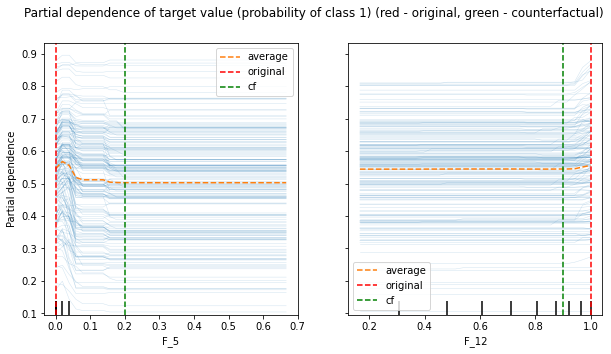

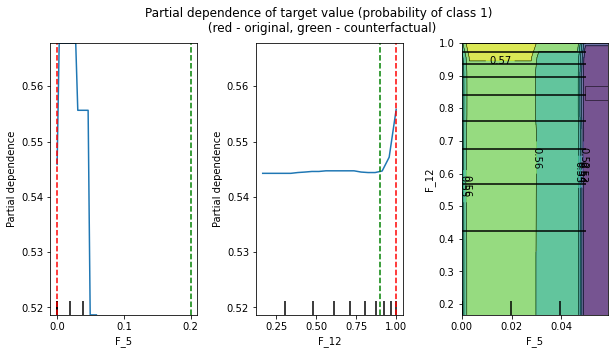

In [37]:
instance_id = 6885
comp.compare_instance(instance_id)